# Emotion Classification in short texts with BERT

Applying BERT to the problem of multiclass text classification. Our dataset consists of written
dialogs, messages and short stories. Each dialog utterance/message is labeled with one of the five
emotion categories: joy, anger, sadness, fear, neutral.

## Workflow:

1. Import Data
2. Data preprocessing and downloading BERT
3. Training and validation
4. Saving the model

Multiclass text classification with BERT and [ktrain](https://github.com/amaiya/ktrain). Use google
colab for a free GPU

👋 **Let's start**


In [1]:
!pip install ktrain


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np

import ktrain
from ktrain import text

from sklearn.model_selection import train_test_split

## 1. Import Data


<Axes: xlabel='emotion'>

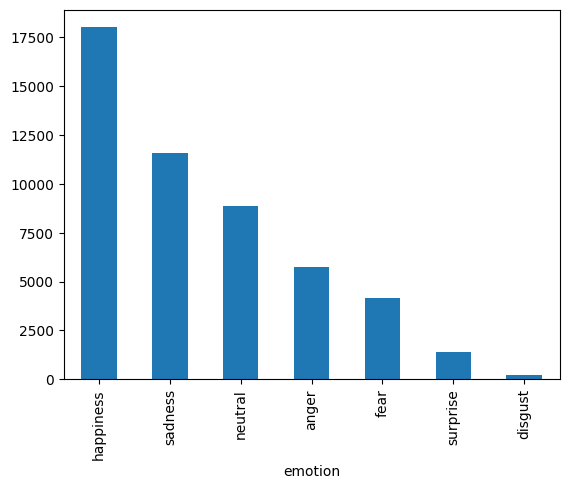

In [3]:
df = pd.read_csv("emotion_data_merged_3.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = df.dropna()
df = df[:50000]

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    df["sentence"], df["emotion"], test_size=0.2, random_state=42
)


class_names = [
    "happiness",
    "sadness",
    "fear",
    "anger",
    "surprise",
    "disgust",
    "neutral",
]


# print(data.Emotion.value_counts())

df["emotion"].value_counts().plot(kind="bar")


# data.head(10)

In [4]:
encoding = {
    "happiness": 0,
    "sadness": 1,
    "fear": 2,
    "anger": 3,
    "surprise": 4,
    "disgust": 5,
    "neutral": 6,
}

# Integer values for each class
y_train = [encoding[x] for x in y_train]
y_test = [encoding[x] for x in y_test]

X_train = X_train.tolist()
X_test = X_test.tolist()

## 2. Data preprocessing

- The text must be preprocessed in a specific way for use with BERT. This is accomplished by setting
  preprocess_mode to ‘bert’. The BERT model and vocabulary will be automatically downloaded

- BERT can handle a maximum length of 512, but let's use less to reduce memory and improve speed.


In [5]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_array(
    x_train=X_train,
    y_train=y_train,
    x_test=X_test,
    y_test=y_test,
    class_names=class_names,
    preprocess_mode="bert",
    maxlen=350,
    max_features=35000,
)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


## 2. Training and validation


Loading the pretrained BERT for text classification


In [6]:
model = text.text_classifier("bert", train_data=(x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 350


/usr/local/lib/python3.11/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


done.


Wrap it in a Learner object


In [7]:
learner = ktrain.get_learner(
    model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=6
)

INFO: Sharding callback duration: 186


Train the model. More about tuning learning rates
[here](https://github.com/amaiya/ktrain/blob/master/tutorial-02-tuning-learning-rates.ipynb)


In [8]:
learner.fit_onecycle(2e-5, 3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
6667/6667 [==============================] - 959s 138ms/step - loss: 0.5147 - accuracy: 0.8214 - val_loss: 0.2544 - val_accuracy: 0.9164
Epoch 2/3
6667/6667 [==============================] - 917s 137ms/step - loss: 0.2100 - accuracy: 0.9312 - val_loss: 0.2068 - val_accuracy: 0.9325
Epoch 3/3
6667/6667 [==============================] - 915s 137ms/step - loss: 0.1029 - accuracy: 0.9654 - val_loss: 0.2092 - val_accuracy: 0.9362


Validation


In [9]:
learner.validate(val_data=(x_test, y_test), class_names=class_names)

313/313 [==============================] - 63s 184ms/step
              precision    recall  f1-score   support

   happiness       0.96      0.96      0.96      3618
     sadness       0.98      0.97      0.97      2261
        fear       0.97      0.94      0.95       828
       anger       0.94      0.93      0.93      1181
    surprise       0.86      0.82      0.84       290
     disgust       0.70      0.46      0.56        41
     neutral       0.85      0.89      0.87      1781

    accuracy                           0.94     10000
   macro avg       0.89      0.85      0.87     10000
weighted avg       0.94      0.94      0.94     10000



array([[3456,    6,    1,   18,    6,    0,  131],
       [   7, 2196,    3,    6,    4,    2,   43],
       [   7,    4,  778,    8,    6,    0,   25],
       [  10,   17,    7, 1094,    5,    3,   45],
       [  11,    2,    4,    2,  239,    0,   32],
       [   0,    2,    2,   10,    1,   19,    7],
       [ 126,   18,   10,   28,   16,    3, 1580]])

#### Testing with other inputs


In [10]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.get_classes()

['happiness', 'sadness', 'fear', 'anger', 'surprise', 'disgust', 'neutral']

In [11]:
import time

message = "I just broke up with my boyfriend"

start_time = time.time()
prediction = predictor.predict(message)

print("predicted: {} ({:.2f})".format(prediction, (time.time() - start_time)))

predicted: sadness (0.12)


In [27]:
df_prediction = pd.read_csv("test_group.csv", sep="\t")

sentences_to_predict = df_prediction["sentence"].tolist()

predicted_emotions = [predictor.predict(sentence) for sentence in sentences_to_predict]

df_prediction["emotion"] = predicted_emotions

df_prediction = df_prediction[["id", "emotion"]]

df_prediction.to_csv("predictions.csv", index=False)

In [21]:
df_prediction.head()

,id,sentence,predicted_emotion
0,0,I get sad when I see a sick animal.,neutral
1,1,Getting punched in the face like that makes my...,anger
2,2,I get anxious near the end of the block.,fear
3,3,being awoken to a shadowy figure at the edge o...,fear
4,4,I am annoyed that my brother didn't wash his d...,anger


## 4. Saving Bert model


In [15]:
# let's save the predictor for later use
predictor.save("models/bebert_model")

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done! to reload the predictor use: ktrain.load_predictor
